In [6]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Define transformations with Data Augmentation

In [2]:
from torchvision import transforms

# Define the transformation pipeline for training data
transform_train = transforms.Compose([
    # Randomly flip the image horizontally with a probability of 0.5
    transforms.RandomHorizontalFlip(),

    # Randomly crop the image to 32x32 pixels with 4 pixels of padding on each side
    # This helps introduce positional variation and prevent overfitting
    transforms.RandomCrop(32, padding=4),

    # Convert the image to a PyTorch tensor (C x H x W format, and values in [0,1])
    transforms.ToTensor(),

    # Normalize the tensor with mean and std deviation of (0.5, 0.5, 0.5) for each RGB channel
    # This centers the data around 0 and scales it to [-1, 1] range
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define the transformation pipeline for test/validation data
transform_test = transforms.Compose([
    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize the tensor in the same way as training data for consistency
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


Load the CIFAR-10 dataset

In [3]:
train_dataset=datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset=datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

#Data Loaders
train_loader=DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader=DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:03<00:00, 43.5MB/s]


In [5]:
print(f'Training data size: {len(train_dataset)}')
print(f'Test data size: {len(test_dataset)}')

Training data size: 50000
Test data size: 10000


Define CNN Architecture

In [8]:
class EnhancedCnn(nn.Module):
    def __init__(self):
        super(EnhancedCnn, self).__init__()

        # First convolutional layer: input channels = 3 (RGB), output channels = 6, kernel size = 5x5
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)

        # Batch normalization after conv1
        self.bn1 = nn.BatchNorm2d(6)

        # Second convolutional layer: input channels = 6, output channels = 16, kernel size = 5x5
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        # Batch normalization after conv2
        self.bn2 = nn.BatchNorm2d(16)

        # Max pooling layer: 2x2 window, stride 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dropout layer with 50% drop rate to reduce overfitting
        self.dropout = nn.Dropout(p=0.5)

        # Dynamically calculate the output size after convolution and pooling to set input size for first FC layer
        self._calculate_conv_output()

        # Fully connected layers
        self.fc1 = nn.Linear(self.conv_output_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # Output layer for 10 classes (e.g., CIFAR-10)

    def _calculate_conv_output(self):
        # Create a dummy input tensor simulating a single 3x32x32 image
        dummy_input = torch.zeros(1, 3, 32, 32)

        with torch.no_grad():
            # Pass dummy input through the convolution and pooling layers
            output = self.pool(F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(dummy_input)))))))

        # Compute the number of features after flattening
        self.conv_output_size = output.numel()  # Total number of elements (C x H x W)

    def forward(self, x):
        # Pass input through first convolutional layer + batch norm + ReLU
        x = F.relu(self.bn1(self.conv1(x)))

        # Pass through second convolutional layer + batch norm + ReLU, then apply max pooling
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)

        # Fully connected layer 1 + ReLU
        x = F.relu(self.fc1(x))

        # Apply dropout for regularization
        x = self.dropout(x)

        # Fully connected layer 2 + ReLU
        x = F.relu(self.fc2(x))

        # Final output layer (no activation — logits returned)
        x = self.fc3(x)

        return x


In [9]:
model=EnhancedCnn()
print(model)

EnhancedCnn(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=2304, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Defining loss function and Optimizer

In [10]:
import torch.nn as nn
import torch.optim as optim

# Define the loss function: CrossEntropyLoss is suitable for multi-class classification
criterion = nn.CrossEntropyLoss()

# Define the optimizer: Adam is an adaptive learning rate optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# List to store the loss value for each epoch
training_loss = []

# Training loop function
def train_model(model, train_loader, criterion, optimizer, epochs=20):
    # Set the model to training mode (important for layers like Dropout and BatchNorm)
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0  # Accumulates loss for this epoch

        # Iterate over batches of images and their corresponding labels
        for images, labels in train_loader:
            # Zero the parameter gradients to avoid accumulation
            optimizer.zero_grad()

            # Forward pass: compute the model output
            outputs = model(images)

            # Compute the loss between predicted and actual labels
            loss = criterion(outputs, labels)

            # Backward pass: compute gradients
            loss.backward()

            # Update model weights
            optimizer.step()

            # Add the current batch loss to running total
            running_loss += loss.item()

        # Average loss for the epoch
        epoch_loss = running_loss / len(train_loader)

        # Store the epoch loss for plotting or analysis
        training_loss.append(epoch_loss)

        # Print the loss for the current epoch
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')


In [11]:
train_model(model, train_loader, criterion, optimizer)

Epoch 1/20, Loss: 1.7841
Epoch 2/20, Loss: 1.5866
Epoch 3/20, Loss: 1.5126
Epoch 4/20, Loss: 1.4572
Epoch 5/20, Loss: 1.4105
Epoch 6/20, Loss: 1.3861
Epoch 7/20, Loss: 1.3599
Epoch 8/20, Loss: 1.3400
Epoch 9/20, Loss: 1.3220
Epoch 10/20, Loss: 1.3112
Epoch 11/20, Loss: 1.3044
Epoch 12/20, Loss: 1.2942
Epoch 13/20, Loss: 1.2876
Epoch 14/20, Loss: 1.2781
Epoch 15/20, Loss: 1.2697
Epoch 16/20, Loss: 1.2565
Epoch 17/20, Loss: 1.2602
Epoch 18/20, Loss: 1.2453
Epoch 19/20, Loss: 1.2465
Epoch 20/20, Loss: 1.2418


Evaluation Loop

Accuracy on the test set: 61.08%


/tmp/ipython-input-13-156115742.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


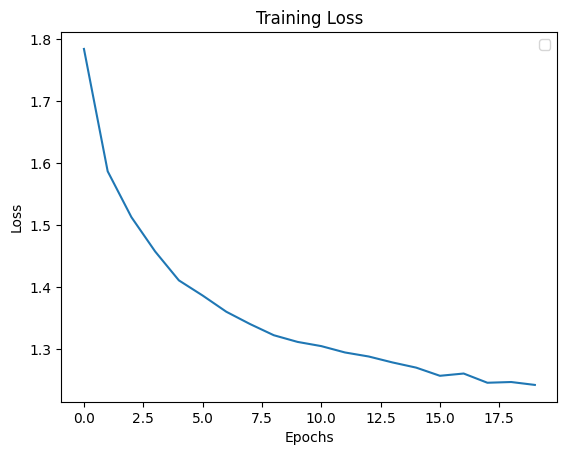

In [13]:
def evaluate_model(model, test_loader):
  model.eval()

  correct=0
  total=0

  with torch.no_grad():
    for images, labels in test_loader:
      outputs=model(images)
      _, predicted=torch.max(outputs, 1)
      total+=labels.size(0)
      correct+=(predicted==labels).sum().item()

  print(f'Accuracy on the test set: {100*correct/total}%')



evaluate_model(model, test_loader)

import matplotlib.pyplot as plt
plt.plot(training_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()
